[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'^GSPC'}, xlabel='Date'>

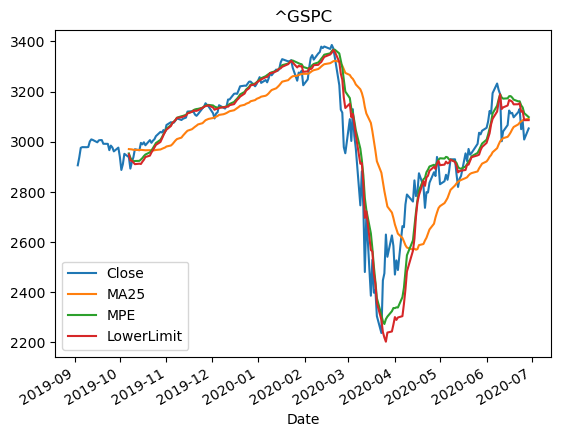

In [99]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyfinance.ols import RollingOLS, PandasRollingOLS

window=25
ticker='^GSPC'
df=yf.download(tickers= ticker,start= '2019-9-01', end='2020-6-30',interval = "1d",
                     group_by = 'column',auto_adjust = True, prepost = True, 
                     proxy = None)
#df=pd.read_csv("ols.csv")
df['X'] = np.arange(len(df))+1
r=PandasRollingOLS(df['Close'], df['X'], window)
df['MPE']=r.alpha+r.beta['feature1']*df['X']
df['SEE']=np.sqrt(((df['Close']-df['MPE'])).fillna(0)**2/(window-2))
df['LowerLimit']=df['MPE']-1.28*df['SEE']
df['MA25']=df['Close'].rolling(window).mean()
df[['Close','MA25','MPE','LowerLimit']].plot(title=ticker)